In [0]:
%tensorflow_version 1.x

# Steps to solve Emergency vs Non-Emergency vehicle classification problem using Image Augmentation

<ol>1. Loading and pre-processing the dataset</ol>
<ol>2. Creating training and validation set</ol>
<ol>3. Augmenting Images</ol>
<ol>4. Defining the model architecture</ol>
<ol>5. Training the model</ol>
<ol>6. Evaluating model performance</ol>

## 1. Loading and pre-processing the dataset

In [1]:
# importing the libraries
import pandas as pd
import numpy as np
from skimage.io import imread
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# libraries for performing image augmentation tasks
from skimage.transform import rotate
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage.transform import AffineTransform, warp

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip /content/drive/My\ Drive/Dataset.zip

Archive:  /content/drive/My Drive/Dataset.zip
   creating: Dataset/
  inflating: Dataset/emergency_classification.csv  
   creating: Dataset/images/
  inflating: Dataset/images/0.jpg    
  inflating: Dataset/images/10.jpg   
  inflating: Dataset/images/1002.jpg  
  inflating: Dataset/images/1006.jpg  
  inflating: Dataset/images/1007.jpg  
  inflating: Dataset/images/1009.jpg  
  inflating: Dataset/images/1013.jpg  
  inflating: Dataset/images/1014.jpg  
  inflating: Dataset/images/1016.jpg  
  inflating: Dataset/images/1019.jpg  
  inflating: Dataset/images/102.jpg  
  inflating: Dataset/images/1020.jpg  
  inflating: Dataset/images/1022.jpg  
  inflating: Dataset/images/1023.jpg  
  inflating: Dataset/images/1026.jpg  
  inflating: Dataset/images/1031.jpg  
  inflating: Dataset/images/1035.jpg  
  inflating: Dataset/images/1036.jpg  
  inflating: Dataset/images/1037.jpg  
  inflating: Dataset/images/104.jpg  
  inflating: Dataset/images/1040.jpg  
  inflating: Dataset/images/1041.jpg

In [0]:
# reading the csv file
data = pd.read_csv('Dataset/emergency_classification.csv')

In [0]:
# create random number generator
seed = 42

In [0]:
# load images and store it in numpy array

# empty list to store the images
X = []
# iterating over each image
for img_name in data.image_names:
    # loading the image using its name
    img = plt.imread('Dataset/images/' + img_name)
    # normalizing the pixel values
    img = img/255
    # saving each image in the list
    X.append(img)
    
# converting the list of images into array
X=np.array(X)

# storing the target variable in separate variable
y = data.emergency_or_not.values

In [0]:
# shape of original dataset
X.shape, y.shape

((2352, 224, 224, 3), (2352,))

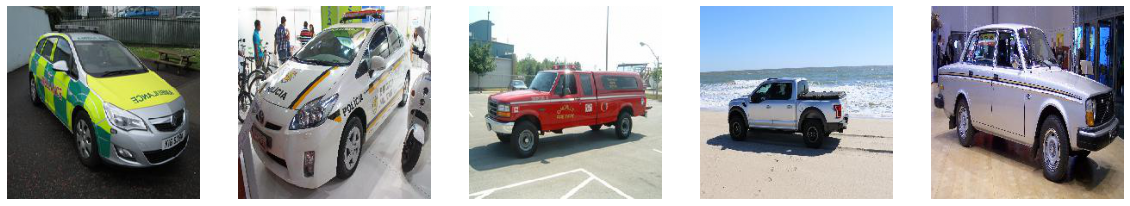

In [0]:
# visualizing images
fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(20,20))
for i in range(5):
    ax[i].imshow(X[i*400])
    ax[i].axis('off')

## 2. Creating training and validation set

In [0]:
# creating a training and validation set
X_train, X_valid, y_train, y_valid=train_test_split(X,y,test_size=0.3, random_state=seed)

In [0]:
# shape of training and validation set
(X_train.shape, y_train.shape), (X_valid.shape, y_valid.shape)

(((1646, 224, 224, 3), (1646,)), ((706, 224, 224, 3), (706,)))

## 3. Augmenting Images

In [0]:
# augmenting the training images
final_train_data = []
final_target_train = []
for i in tqdm(range(X_train.shape[0])):
    # original image
    final_train_data.append(X_train[i])
    # image rotation
    final_train_data.append(rotate(X_train[i], angle=30, mode = 'edge'))
    # image flipping (left-to-right)    
    final_train_data.append(np.fliplr(X_train[i]))
    # image flipping (up-down) 
    final_train_data.append(np.flipud(X_train[i]))
    # image noising
    final_train_data.append(random_noise(X_train[i],var=0.2))
    for j in range(5):
        final_target_train.append(y_train[i])

100%|██████████| 1646/1646 [00:22<00:00, 72.40it/s]


In [0]:
# converting images and target to array
final_train = np.array(final_train_data)
final_target_train = np.array(final_target_train)

In [0]:
# shape of new training set
final_train.shape, final_target_train.shape 

((8230, 224, 224, 3), (8230,))

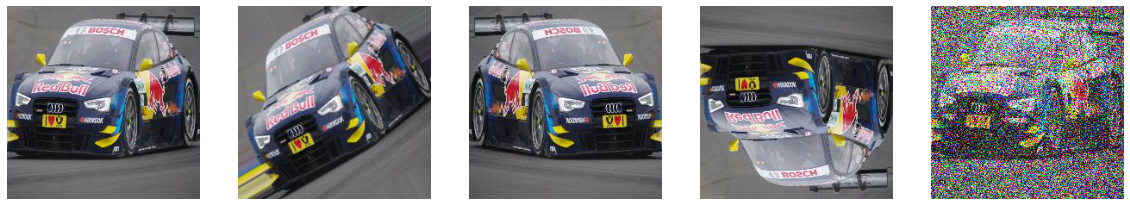

In [0]:
# visualizing the augmented images
fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(20,20))
for i in range(5):
    ax[i].imshow(final_train[i+30])
    ax[i].axis('off')

In [0]:
# converting 3 dimensional image to 1 dimensional image
final_train = final_train.reshape(final_train.shape[0], 224*224*3)
final_train.shape

(8230, 150528)

In [0]:
# minimum and maximum pixel values of training images
final_train.min(), final_train.max()

(0.0, 1.0)

In [0]:
# converting 3 dimensional validation image to 1 dimensional image
final_valid = X_valid.reshape(X_valid.shape[0], 224*224*3)
final_valid.shape

(706, 150528)

In [0]:
# minimum and maximum pixel values of validation images
final_valid.min(), final_valid.max()

(0.0, 1.0)

## 4. Defining the model architecture

In [0]:
# importing functions from keras to define the neural network architecture
from keras.layers import Dense, InputLayer, Dropout, BatchNormalization
from keras.models import Sequential
# importing adam optimizer from keras optimizer module 
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
# defining the adam optimizer and setting the learning rate as 10^-5
adam = Adam(lr=1e-5)

In [0]:
# defining and compiling the model architecture
model=Sequential()

model.add(InputLayer(input_shape=(224*224*3,)))
model.add(Dense(100, activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
model.add(Dense(100, activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               15052900  
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

## 5. Training the model

In [0]:
# training the model
model_history = model.fit(final_train, final_target_train, epochs=50, batch_size=128,validation_data=(final_valid,y_valid))




Train on 8230 samples, validate on 706 samples
Epoch 1/50





8230/8230 [==============================] - 16s 2ms/step - loss: 0.8911 - acc: 0.5815 - val_loss: 0.6081 - val_acc: 0.6898
Epoch 2/50
8230/8230 [==============================] - 8s 952us/step - loss: 0.7706 - acc: 0.6283 - val_loss: 0.6708 - val_acc: 0.6601
Epoch 3/50
8230/8230 [==============================] - 8s 949us/step - loss: 0.7188 - acc: 0.6563 - val_loss: 0.5717 - val_acc: 0.7153
Epoch 4/50
8230/8230 [==============================] - 8s 951us/step - loss: 0.6738 - acc: 0.6765 - val_loss: 0.5444 - val_acc: 0.7252
Epoch 5/50
8230/8230 [==============================] - 8s 953us/step - loss: 0.6455 - acc: 0.6943 - val_loss: 0.5512 - val_acc: 0.7167
Epoch 6/50
8230/8230 [==============================] - 8s 956us/step - loss: 0.6175 - acc: 0.7148 - val_loss: 0.6086 - val_acc: 0.6898
Epoch 7/50
8230/8230 [==============================] - 8s 955us/step - loss: 0.5814 - acc: 0.7388 - val_loss: 0.6515 - val_acc: 0

## 6. Evaluating model performance

In [0]:
# accuracy on validation set
print('Accuracy on validation set:', accuracy_score(y_valid, model.predict_classes(final_valid)[:, 0]), '%')

Accuracy on validation set: 0.7152974504249292 %


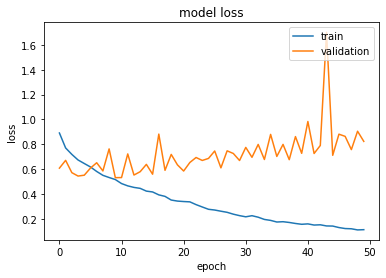

In [0]:
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

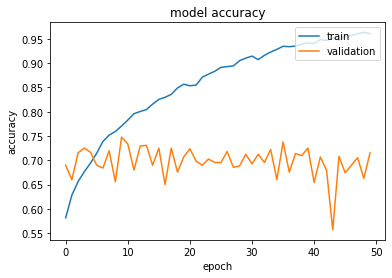

In [0]:
# summarize history for accuracy
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()